In [1]:
import numpy as np
import fiona
import os
import gdal
from rasterstats import zonal_stats
from math import ceil,floor
import matplotlib.pyplot as plt
import datetime
from IPython.display import HTML, display

<img src="data/thumb.png" alt="Drawing" style="width: 300px;"/>

In [2]:
Grid_Name = os.path.join('data', 'nlcd_2011_impervious_2011_edition_2014_10_cbw.img')
Shapefile_Name = os.path.join('test', 'testPolyCBWall.shp')
#Grid_Name = "data\\nlcd_2011_impervious_2011_edition_2014_10_cbw.img"
#Shapefile_Name = "test\\testPolyCBWall.shp"

In [3]:
r = gdal.Open(Grid_Name)
r.GetGeoTransform()

(1295370.0000000037, 30.0, 0.0, 2448507.000000002, 0.0, -30.0)

In [5]:
class dtFZS:
    def __init__(self, img):

        self.r = gdal.Open(Grid_Name)
        self.g = np.array(self.r.GetRasterBand(1).ReadAsArray())
        
        self.clSze = self.r.GetGeoTransform()[1]
        self.ulX = self.r.GetGeoTransform()[0]
        self.ulY = self.r.GetGeoTransform()[3]
        
        self.brX = (self.g.shape[0] * self.clSze) + self.ulX
        self.brY = self.ulY - (self.g.shape[0] * self.clSze)   
        
        self.geo = self.r.GetGeoTransform()
        
        def dtFZS(g,out):
            for xw in range(0,self.g.shape[1]):
                ##print(xw/g.shape[1])
                for yw in range(0,self.g.shape[0]):
                    out[yw,xw] = out[yw-1,xw] + self.g[yw,xw]

                    
        self.data = np.zeros(self.g.shape,dtype='uint64')
        
        dtFZS(self.g,self.data)

In [6]:
## Create Class for this grid
print(datetime.datetime.now())
dFZS = dtFZS(Grid_Name)
print(datetime.datetime.now())

2019-12-31 14:44:22.239517
2019-12-31 14:51:32.530315


Create Helper Functions to move between world and grid cordinates

In [7]:
## Input (world cords; x1, x2, Grid Upper Left, and Cellsize)
## Returns (grid cords; list(x))
## x1 and x2 represent vertexes on a polygon in order

def x_world_to_grid(wx1,wx2,dtFZS):
    
    x1a = min(wx1,wx2)
    x2a = max(wx1,wx2)
    
    xstart = int ( ceil  ((x1a - dtFZS.ulX - (dtFZS.clSze/2)) / dtFZS.clSze))
    xstop =  int ( floor ((x2a - dtFZS.ulX - (dtFZS.clSze/2)) / dtFZS.clSze))

    return(list(range(xstart,xstop+1)))

In [8]:
## Input (grid cords; list(x))
## Returns(world cords centroid ;(list(X)))

def x_grid_to_world(gx,dtFZS):
    return [i * dtFZS.clSze + dtFZS.ulX + (dtFZS.clSze/2) for i in gx]

In [9]:
## Input(world cords centroid ;(list(X)))
## Returns(world cords centroid ;(list(y)))

def y_world_pred(wx1,wx2,wy1,wy2,wxpred):
    slope = 0;
    if (wx1 > wx2):
        wx1,wx2,wy1,wy2 = wx2,wx1,wy2,wy1
    if(wx1 != wx2):    
        slope = (wy2-wy1)/(wx2-wx1)

    return [(slope * (i-wx1)) + wy1 for i in wxpred]

In [10]:
## Input(world cords centroid ;(list(y)))
## Returns (grid cords; list(y))

def y_world_to_grid(wypred,dtFZS):
        return [int ( floor((dtFZS.ulY - i - (dtFZS.clSze/2)) / dtFZS.clSze )) for i in wypred] 

In [11]:
## Input(world Cords for 2 vertexes on a polygon, TL corner of grid, and cellsize)
## Returns(y,x grid cords)

def xy_grid(wx1,wx2,wy1,wy2,dtFZS):
    xgrid  = x_world_to_grid(wx1,wx2,dtFZS)
    wxpred = x_grid_to_world(xgrid,dtFZS)  
    wypred = y_world_pred(wx1,wx2,wy1,wy2,wxpred)
    ygrid  = y_world_to_grid(wypred,dtFZS)
    
    ## Remove negative arrays above
    idx = np.array([True if i >= 0 else False for i in ygrid],dtype=bool)
    
    xgrid = np.array(xgrid)[idx]
    ygrid = np.array(ygrid)[idx]
    
    cords = ((ygrid,xgrid))
    return cords

In [12]:
## Input(list of cords in world, summed down grid, real-world grid tl, cllSze)
## Output Sum v in polygon

def FstZS(feat,DS_FstZS):
    v = feat['geometry']['coordinates'][0]  #have not tested
    total = 0;    
    for p in range(1,(len(v)+0)):
        if v[p][0] > v[p-1][0]:
            cords = xy_grid(v[p][0],v[p-1][0],v[p][1],v[p-1][1],DS_FstZS)
            if len(cords[0]) > 0:
                total -= np.sum(DS_FstZS.data[cords])
        elif v[p][0] < v[p-1][0]: 
            cords = xy_grid(v[p][0],v[p-1][0],v[p][1],v[p-1][1],DS_FstZS)
            if len(cords[0]) > 0:
                total += np.sum(DS_FstZS.data[cords])
    return int(total)

In [13]:
## Input(fiona geometry)
## Returns a tuple with the FstZS and rasterstats output

def test(feat):
    
    start = datetime.datetime.now()
    FstZSout = FstZS(feat, dFZS)
    middle = datetime.datetime.now()
    Rastsout = zonal_stats(feat, Grid_Name,stats= "sum", nodata=None)
    end = datetime.datetime.now()
    
    return (float(FstZSout) , float(Rastsout[0]['sum']),(middle-start).total_seconds(),(end-middle).total_seconds(),feat['properties']['area_km']/1000 )

In [14]:
## Loops over input shapefile polygons and runs the test function on each

maxHucLevel = 2

tst = list()

for feat in fiona.open(Shapefile_Name):
    if feat['properties']['hucLevel'] >= maxHucLevel:
        result = test(feat)
        tst.append(result)
        print('completed hucLevel:',feat['properties']['hucLevel'],'results:',result)
        

completed hucLevel: 2 results: (464936066.0, 464936066.0, 1.833366, 57.007403, 178.019721)
completed hucLevel: 4 results: (75097455.0, 75097455.0, 1.012512, 2.289188, 15.207301)
completed hucLevel: 4 results: (138308609.0, 138308609.0, 2.120579, 4.271189, 38.018177)
completed hucLevel: 4 results: (137562599.0, 137562599.0, 1.669631, 5.155086, 71.22379)
completed hucLevel: 4 results: (113967403.0, 113967403.0, 2.000544, 3.437739, 53.570454)
completed hucLevel: 6 results: (75097455.0, 75097455.0, 0.275686, 0.987272, 15.207301)
completed hucLevel: 6 results: (15682206.0, 15682206.0, 1.030675, 1.120423, 18.074811)
completed hucLevel: 6 results: (43807532.0, 43807532.0, 0.602377, 2.253585, 29.283937)
completed hucLevel: 6 results: (75733292.0, 75733292.0, 0.660162, 1.700208, 26.789527)
completed hucLevel: 8 results: (30722824.0, 30722824.0, 0.232831, 0.435893, 6.439274999999999)
completed hucLevel: 8 results: (2307558.0, 2307558.0, 0.292484, 0.403604, 3.585221)
completed hucLevel: 8 results

[(464936066.0, 464936066.0, 1.833366, 57.007403, 178.019721), (75097455.0, 75097455.0, 1.012512, 2.289188, 15.207301), (138308609.0, 138308609.0, 2.120579, 4.271189, 38.018177), (137562599.0, 137562599.0, 1.669631, 5.155086, 71.22379), (113967403.0, 113967403.0, 2.000544, 3.437739, 53.570454), (75097455.0, 75097455.0, 0.275686, 0.987272, 15.207301), (15682206.0, 15682206.0, 1.030675, 1.120423, 18.074811), (43807532.0, 43807532.0, 0.602377, 2.253585, 29.283937), (75733292.0, 75733292.0, 0.660162, 1.700208, 26.789527), (30722824.0, 30722824.0, 0.232831, 0.435893, 6.439274999999999), (2307558.0, 2307558.0, 0.292484, 0.403604, 3.585221), (7606454.0, 7606454.0, 0.488613, 0.468288, 5.240268), (3527751.0, 3527751.0, 0.115013, 0.294088, 2.142433), (463238.0, 463238.0, 0.084307, 0.220372, 0.6378039999999999), (355028.0, 355028.0, 0.175117, 0.266003, 0.826843), (6180231.0, 6180231.0, 0.125485, 0.229034, 0.891386), (457054.0, 457054.0, 0.055934, 0.195578, 0.6289260000000001), (57067.0, 57067.0, 0

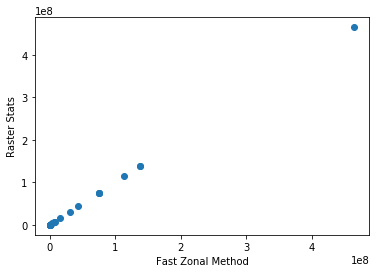

In [15]:
print(tst)
plt.scatter(y=[t[1] for t in tst],x= [t[0] for t in tst])
plt.xlabel("Fast Zonal Method")
plt.ylabel("Raster Stats")              
plt.show()   

[(464936066.0, 464936066.0, 1.833366, 57.007403, 178.019721), (75097455.0, 75097455.0, 1.012512, 2.289188, 15.207301), (138308609.0, 138308609.0, 2.120579, 4.271189, 38.018177), (137562599.0, 137562599.0, 1.669631, 5.155086, 71.22379), (113967403.0, 113967403.0, 2.000544, 3.437739, 53.570454), (75097455.0, 75097455.0, 0.275686, 0.987272, 15.207301), (15682206.0, 15682206.0, 1.030675, 1.120423, 18.074811), (43807532.0, 43807532.0, 0.602377, 2.253585, 29.283937), (75733292.0, 75733292.0, 0.660162, 1.700208, 26.789527), (30722824.0, 30722824.0, 0.232831, 0.435893, 6.439274999999999), (2307558.0, 2307558.0, 0.292484, 0.403604, 3.585221), (7606454.0, 7606454.0, 0.488613, 0.468288, 5.240268), (3527751.0, 3527751.0, 0.115013, 0.294088, 2.142433), (463238.0, 463238.0, 0.084307, 0.220372, 0.6378039999999999), (355028.0, 355028.0, 0.175117, 0.266003, 0.826843), (6180231.0, 6180231.0, 0.125485, 0.229034, 0.891386), (457054.0, 457054.0, 0.055934, 0.195578, 0.6289260000000001), (57067.0, 57067.0, 0

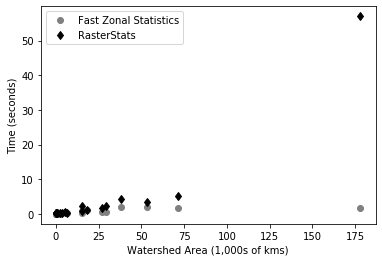

In [16]:
print(tst)
##plt.scatter(y=[t[3].total_seconds() for t in tst],x= [t[2].total_seconds() for t in tst])
fig = plt.figure()
ax = plt.axes()

plt.xlabel("Watershed Area (1,000s of kms)")
plt.ylabel("Time (seconds)")

x1 = [t[4] for t in tst]
y1 = [t[2] for t in tst]
y2 = [t[3] for t in tst]



##slope_fst, intercept_fst, r_value_fst, p_value_fst, std_err_fst = stats.linregress(x1,y1)
##line_fst = [x*slope_fst+intercept_fst for x in x1]

##slope_rst, intercept_rst, r_value_rst, p_value_rst, std_err_rst = stats.linregress(x1,y2)
##line_rst = [x*slope_rst+intercept_rst for x in x1]

##plt.plot(x1, line_fst,color= (0.5, 0.5, 0.5),label='y={:.2f}x+{:.2f}'.format(slope_fst,intercept_fst) )
##plt.plot(x1, line_rst,color= (0.5, 0.5, 0.5),label='y={:.2f}x+{:.2f}'.format(slope_rst,intercept_rst) )


plt.plot(x1,y1,'o',label='Fast Zonal Statistics',color= (0.5, 0.5, 0.5))
plt.plot(x1,y2,'kd',label='RasterStats')

##plt.axis('equal')
##plt.xlim(0, 20)
##plt.ylim(0, 20)

ax.legend()
plt.show() 